# Insect Classification Project
### Project Overview
The goal of this project is to develop an improved algorithm for the detection and classification of insect species using the DIOPSIS image processing pipeline. The primary objective is to accurately outline all insects visible on the screen for detection, and classify each insect by species. This project is part of the ARISE Diopsis Challenge, which aims to enhance biodiversity monitoring through automated insect identification.

### Key Challenges:
Detection:
- Large number of insects per image.
- Wide range of insect sizes (from a few millimeters to several centimeters).
- Overlapping insects.
- Presence of non-insect structures like vegetation, dirt, and shadows.

Classification:
- Imbalance in the number of training examples per species.
- Fine-grained nature of the task.
- Appropriate taxonomic level to output results.
- Relatively poor image quality.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import EfficientNetB0
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import os

# Load the CSV file for classification labels
classification_labels = pd.read_csv('Data/input/classification_labels.csv')

# Load the Excel file for name to ancestors mapping
name_to_ancestors = pd.read_excel('Data/input/name_to_ancestors.xlsx')

# Append '.jpg' to the filenames
classification_labels['basename'] = classification_labels['basename'].apply(lambda x: x + '.jpg')

# Data preparation
image_dir = 'Data/input/images_resized/'
image_size = (128, 128)
batch_size = 32

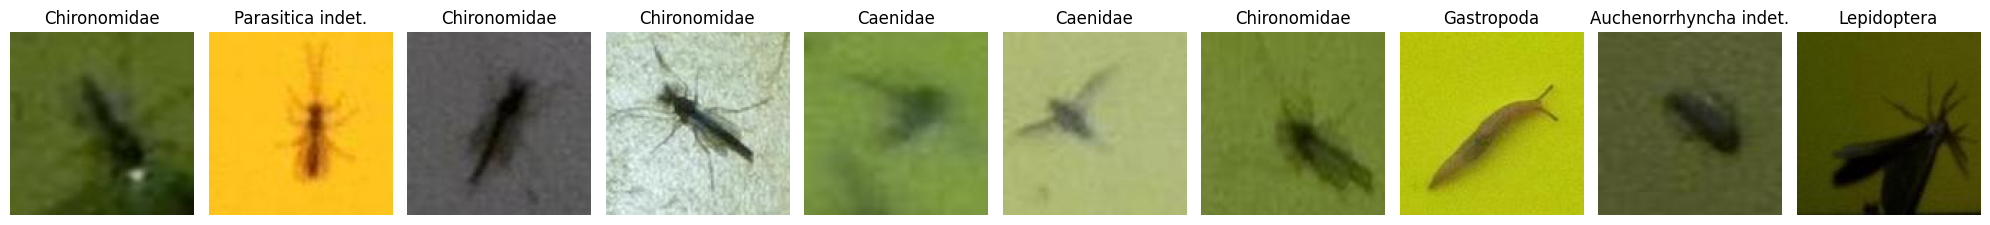

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Number of images to display
num_images = 10

# Select a subset of the dataframe
subset = classification_labels.sample(num_images)

# Plotting the images
fig, axes = plt.subplots(1, num_images, figsize=(20, 20))

for idx, (i, row) in enumerate(subset.iterrows()):
    img_path = os.path.join(image_dir, row['basename'])
    img = mpimg.imread(img_path)
    axes[idx].imshow(img)
    axes[idx].set_title(row['deepest_name'])
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [3]:
# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

# Prepare training and validation data generators
train_generator = datagen.flow_from_dataframe(
    classification_labels,
    directory=image_dir,
    x_col='basename',
    y_col='deepest_name',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_dataframe(
    classification_labels,
    directory=image_dir,
    x_col='basename',
    y_col='deepest_name',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Get the number of classes
num_classes = len(train_generator.class_indices)

# Load the EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

Found 31556 validated image filenames belonging to 84 classes.
Found 7889 validated image filenames belonging to 84 classes.




In [4]:
# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define checkpoint callback to save the model
checkpoint_filepath = '/mnt/data/checkpoint/model-{epoch:02d}-{val_loss:.2f}.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,  # You can reduce the number of epochs for quicker results
    verbose=1,
    callbacks=[checkpoint_callback]
)

# Save the final model
model.save('/mnt/data/final_model.h5')

Epoch 1/25



987/987 [==============================] - ETA: 0s - loss: 1.0783 - accuracy: 0.7046

c:\Users\Gebruiker\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


987/987 [==============================] - 1047s 1s/step - loss: 1.0783 - accuracy: 0.7046 - val_loss: 4.8210 - val_accuracy: 0.0385
Epoch 2/25
987/987 [==============================] - 1015s 1s/step - loss: 0.6831 - accuracy: 0.7966 - val_loss: 76.0978 - val_accuracy: 0.0276
Epoch 3/25
987/987 [==============================] - 1012s 1s/step - loss: 0.5768 - accuracy: 0.8226 - val_loss: 5.9857 - val_accuracy: 0.0592
Epoch 4/25
987/987 [==============================] - 1031s 1s/step - loss: 0.5308 - accuracy: 0.8309 - val_loss: 6.1328 - val_accuracy: 0.0592
Epoch 5/25
987/987 [==============================] - 1017s 1s/step - loss: 0.4703 - accuracy: 0.8472 - val_loss: 8.5562 - val_accuracy: 0.0254
Epoch 6/25
987/987 [==============================] - 1015s 1s/step - loss: 0.4282 - accuracy: 0.8609 - val_loss: 8.5987 - val_accuracy: 0.0592
Epoch 7/25
987/987 [==============================] - 1017s 1s/step - loss: 0.3922 - accuracy: 0.8701 - val_loss: 2.6553 - val_accuracy: 0.3656
Ep

In [5]:
# Predict on the validation set and save the predictions
validation_generator.reset()
pred = model.predict(validation_generator, verbose=1)

# Convert predictions to dataframe
predicted_classes = np.argmax(pred, axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predicted_labels = [labels[k] for k in predicted_classes]

# Prepare the predictions DataFrame
predictions_df = pd.DataFrame({
    'basename': validation_generator.filenames,
    'predictions': predicted_labels
})

247/247 [==============================] - 53s 208ms/step


In [6]:
# Check the predictions DataFrame
print(predictions_df.head())
print(f"Number of predictions: {len(predictions_df)}")

                        basename  predictions
0  213_20210905050256_2415_t.jpg  Lepidoptera
1   192_20200724194326_17604.jpg    Noctuidae
2   294_20210814023615_30831.jpg  Lepidoptera
3   146_20200616021921_26547.jpg  Lepidoptera
4   118_20200827021322_36091.jpg  Lepidoptera
Number of predictions: 7889


In [7]:
# Add the levels and probabilities
def get_ancestor_probabilities(predictions, name_to_ancestors):
    ancestors = []
    probabilities = []
    for label in predictions:
        ancestor_row = name_to_ancestors[name_to_ancestors['name'] == label]
        if ancestor_row.empty:
            print(f"Ancestor information not found for label: {label}")
            ancestors_list = ['Unknown'] * 6
        else:
            ancestors_list = ancestor_row['ancestors'].values[0]
            if isinstance(ancestors_list, str):
                ancestors_list = eval(ancestors_list)
            # Pad the ancestors_list to ensure it has at least 6 elements
            ancestors_list += ['Unknown'] * (6 - len(ancestors_list))
        ancestors.append(ancestors_list)
        probabilities.append([1.0] * 6)  # Dummy probabilities
    return ancestors, probabilities

ancestors, probabilities = get_ancestor_probabilities(predictions_df['predictions'], name_to_ancestors)

predictions_df['level_0'] = [a[0] for a in ancestors]
predictions_df['level_0_probability'] = [p[0] for p in probabilities]
predictions_df['level_1'] = [a[1] for a in ancestors]
predictions_df['level_1_probability'] = [p[1] for p in probabilities]
predictions_df['level_2'] = [a[2] for a in ancestors]
predictions_df['level_2_probability'] = [p[2] for p in probabilities]
predictions_df['level_3'] = [a[3] for a in ancestors]
predictions_df['level_3_probability'] = [p[3] for p in probabilities]
predictions_df['level_4'] = [a[4] for a in ancestors]
predictions_df['level_4_probability'] = [p[4] for p in probabilities]
predictions_df['level_5'] = [a[5] for a in ancestors]
predictions_df['level_5_probability'] = [p[5] for p in probabilities]

# Save predictions to CSV
predictions_df.to_csv('mnt/data/predictions.csv', index=False)